In [2]:
import numpy as np
import pandas as pd
from scipy import sparse
import networkx as nx
import matplotlib.pyplot as plt
# import janitor as jn
import sparse as sprs

In [3]:
G = nx.random_graphs.connected_watts_strogatz_graph(25, 4, 0.7)

nx.set_edge_attributes(G, values = 1, name = 'weight')
nx.set_node_attributes(G, nx.pagerank(G), name='importance')

In [4]:
G[0]

AtlasView({21: {'weight': 1}, 24: {'weight': 1}, 4: {'weight': 1}, 10: {'weight': 1}})

In [5]:
G.nodes[0]

{'importance': 0.03835396207607824}

per the [documentation](https://networkx.org/documentation/latest/reference/introduction.html#graph-reporting):

> Any properties that are more complicated than edges, neighbors and degree are provided by functions.

In [6]:
nodelist = (
    pd.DataFrame.from_dict(dict(G.nodes.data()), orient='index')
    .assign(name=lambda df: 'node_'+df.index.astype(str))
    .rename_axis(index='nid')
)
edgelist = (
    nx.to_pandas_edgelist(G)
    .rename_axis(index='eid')
    .assign(name=lambda df: 'edge_'+df.index.astype(str))
)#.reset_index()
# pd.Series.str.cat()
# pd.DataFrame.assign()

# incidences = (edgelist
#               .melt(id_vars=['eid', 'weight'], value_vars=['source', 'target'])
#               .assign(weight=lambda df: df['weight'].where(df['variable']=='target', -1))
#              )

In [7]:
nodelist

,importance,name
nid,,
0,0.038354,node_0
1,0.034640,node_1
2,0.038940,node_2
3,0.033501,node_3
4,0.038690,node_4
5,0.038762,node_5
6,0.022782,node_6
7,0.029975,node_7
8,0.084035,node_8


In [8]:
edgelist

,source,target,weight,name
eid,,,,
0,0,21,1,edge_0
1,0,24,1,edge_1
2,0,4,1,edge_2
3,0,10,1,edge_3
4,1,3,1,edge_4
5,1,12,1,edge_5
6,1,15,1,edge_6
7,2,4,1,edge_7
8,2,19,1,edge_8


In [21]:
multi = pd.DataFrame(
    data=edgelist.weight.values,
    index=pd.MultiIndex.from_arrays((edgelist.index,edgelist.source))
)
%timeit multi.unstack(level=1)


970 µs ± 69.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [42]:
%%timeit 
sparse.coo_array(
    (multi[0].values, (multi.index.levels[0].values, edgelist.source)), 
    shape=(edgelist.shape[0], nodelist.shape[0])
)

123 µs ± 7.46 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
# %%timeit
Eout = sparse.coo_array(
    (edgelist.weight, (edgelist.index, edgelist.source)), 
    shape=(edgelist.shape[0], nodelist.shape[0])
)
Ein = sparse.coo_array(
    (edgelist.weight, (edgelist.index, edgelist.target)), 
    shape=(edgelist.shape[0], nodelist.shape[0])
)

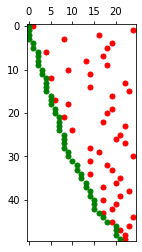

In [9]:
plt.spy(Ein, marker='.', color='r')
plt.spy(Eout, marker='.', color='g')

0

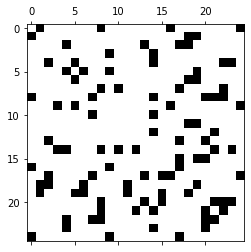

In [10]:
A = Eout.T@Ein+Ein.T@Eout  # Undirected Adjacency matrix

plt.spy(A.toarray())
# B.toarray()@B.toarray().T
(Eout.T@Ein)[1,1]

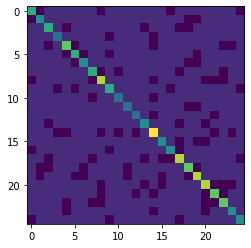

In [11]:
Eorient = Eout - Ein  # has (arbitrary) directionality on E
plt.imshow((Eorient.T@Eorient).toarray())  # should be the laplacian...

In [12]:
def normalize(W):
    #Find the row scalars as a Matrix_(n,1)
    rowSumW = sparse.csr_array(W.sum(axis=0))
    rowSumW.data = 1/rowSumW.data

    #Find the diagonal matrix to scale the rows
#     rowSumW = rowSumW.transpose()
#     scaling_matrix = sparse.diags(rowSumW.toarray()[0])
    print(W.shape, rowSumW.shape)
    return W*rowSumW 

normalize(Ein)[[1],:].toarray()

(50, 25) (1, 25)


array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.33333333]])

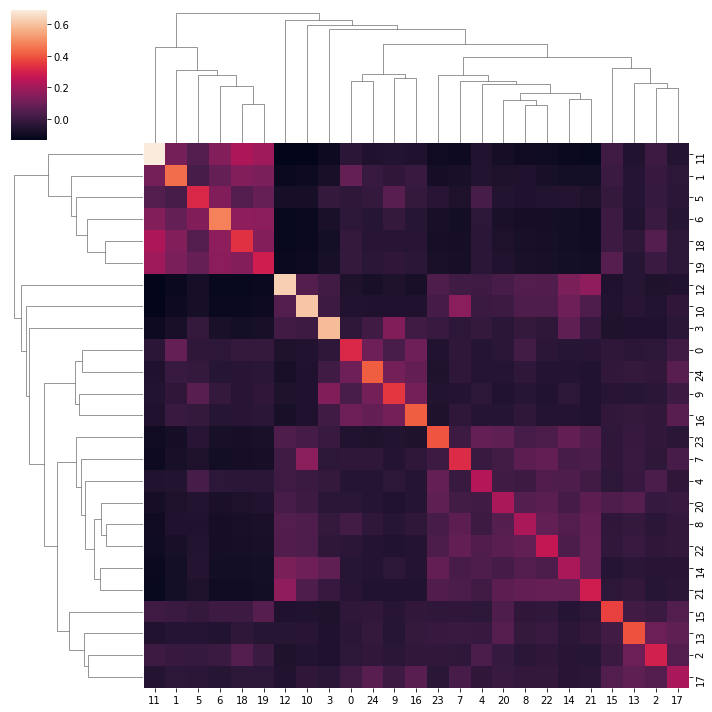

In [14]:
import seaborn as sns
from scipy import linalg
Linv = linalg.pinv((Eorient.T@Eorient).toarray())
sns.clustermap(Linv)

matrix([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

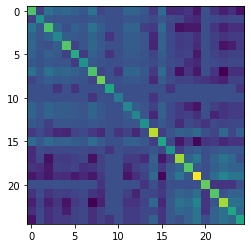

In [24]:
# from scipy import linalg
def empirical_timelike(E):
    return np.sqrt(1+(E*E).sum(axis=0))

def hyperboledge(E):
    return sparse.vstack((E, empirical_timelike(E)), format='csr')

def logmap

# def hyperdot(X, mink_coord=-1):
    
# def hyperbolaplacian()
hypE = (hyperboledge(Ein)-hyperboledge(Eout)) # BAD (can't "add" hyperbolic vectors)
plt.imshow((hypE.T@hypE).toarray())

hyperboledge(Ein).multiply(hyperboledge(Ein))[:-1].sum(axis=0) - hyperboledge(Ein).multiply(hyperboledge(Ein))[-1]

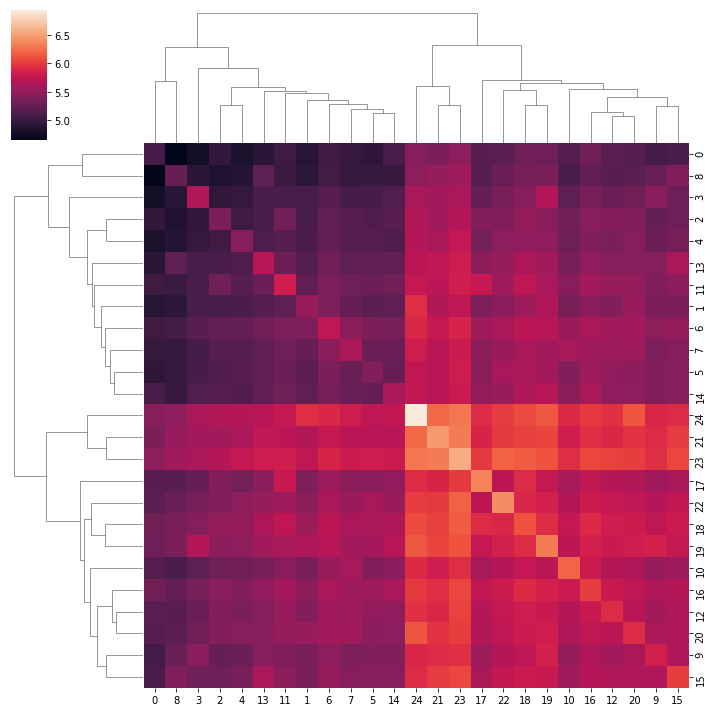

In [276]:
hypLinv = linalg.pinv((hypE.T@hypE).toarray())


sns.clustermap(hypLinv)

/home/tbsexton/miniconda3/envs/grabble/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


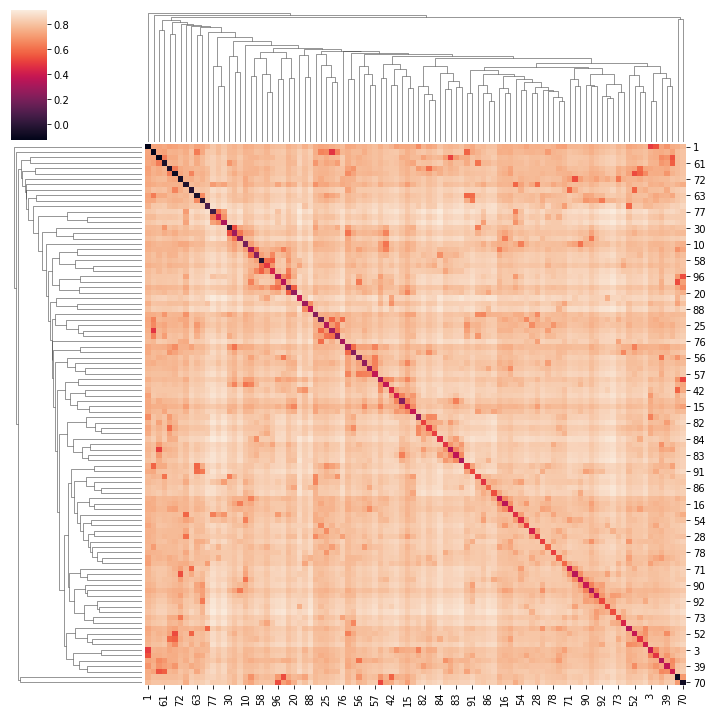

In [249]:
sns.clustermap(hypLinv/hypLinv.max()-Linv/Linv.max())

In [15]:
(Eorient.T@Eorient)[1,1]

6

In [17]:

np.all(np.diagflat(A.sum(axis=1))-A == Eorient.T@Eorient)  # Indeed, That got us the laplacian! :D

True

In [39]:
B = sparse.coo_array((incidences.weight, (incidences.index, incidences.value)))
B

<400x100 sparse array of type '<class 'numpy.int64'>'
	with 400 stored elements in COOrdinate format>

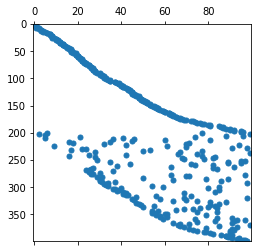

In [5]:
plt.spy(B, aspect = B.shape[1]/B.shape[0], marker='.')

In [6]:
%timeit sparse.coo_array((edgelist.weight, (edgelist.source, edgelist.target)))

127 µs ± 1.11 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


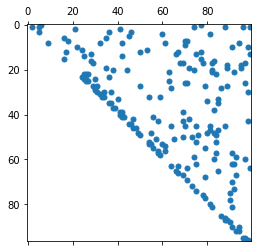

In [7]:
plt.spy(sparse.coo_array((edgelist.weight, (edgelist.source, edgelist.target))), marker='.')

In [8]:
Barr = B.toarray()
Bdf = pd.DataFrame.sparse.from_spmatrix(B)

%timeit B@B.T
%timeit Barr@Barr.T
%timeit Bdf@Bdf.T

220 µs ± 20 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
9.08 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
32.4 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


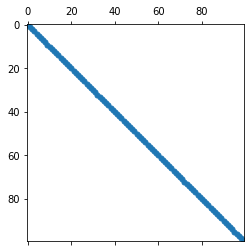

In [9]:
plt.spy(B.T.dot(B), marker='.') # something's not right...

# AnnData?

In [34]:
import anndata as ad

In [45]:
adata = ad.AnnData(
    X=(Ein+Eout).tocsc(), 
    layers={
        'Ein':Ein.tocsr(),
        'Eout':Eout.tocsr(),
    },
    obs=edgelist.set_index('eid'),
    
)

ValueError: Value passed for key 'Ein' is of incorrect shape. Values of layers must match dimensions (0, 1) of parent. Value had shape (200, 100) while it should have had (200, 0).

In [335]:
adata.X

<200x100 sparse array of type '<class 'numpy.float32'>'
	with 400 stored elements in Compressed Sparse Column format>

In [336]:
adata.obs_names = [f"edge_{i:d}" for i in range(adata.n_obs)]
adata.var_names = [f"node_{i:d}" for i in range(adata.n_vars)]
adata.obs_names[:10]

Index(['edge_0', 'edge_1', 'edge_2', 'edge_3', 'edge_4', 'edge_5', 'edge_6',
       'edge_7', 'edge_8', 'edge_9'],
      dtype='object')

In [337]:
adata[['edge_1', 'edge_5'], ['node_4', 'node_10']].X

<2x2 sparse matrix of type '<class 'numpy.float32'>'
	with 0 stored elements in Compressed Sparse Column format>

In [338]:
adata.varp['adj'] = Eout.T@Ein+Ein.T@Eout
adata.varp['adj']


<100x100 sparse array of type '<class 'numpy.int64'>'
	with 400 stored elements in Compressed Sparse Row format>

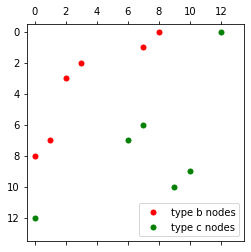

In [345]:
rng = np.random.default_rng(42)
node_cats = rng.choice(["a", "b", "c"], size=(adata.n_vars,), p=[0.5, 0.3,0.2])
adata.var["node_types"] = pd.Categorical(node_cats)
plt.spy(adata[:,adata.var.node_types=='b'].varp['adj'], 
        marker='.', color='r', label='type b nodes')
plt.spy(adata[:,adata.var.node_types=='c'].varp['adj'], 
        marker='.', color='g', label='type c nodes')
plt.legend()

In [352]:
type(adata.varp).mro()
# G = ad.AnnData()

[anndata._core.aligned_mapping.PairwiseArrays,
 anndata._core.aligned_mapping.AlignedActualMixin,
 anndata._core.aligned_mapping.PairwiseArraysBase,
 anndata._core.aligned_mapping.AlignedMapping,
 collections.abc.MutableMapping,
 collections.abc.Mapping,
 collections.abc.Collection,
 collections.abc.Sized,
 collections.abc.Iterable,
 collections.abc.Container,
 abc.ABC,
 object]

In [326]:
alldata.var_names

Index(['node_0', 'node_1', 'node_2', 'node_3', 'node_4', 'node_5', 'node_6',
       'node_7', 'node_8', 'node_9', 'node_10', 'node_11', 'node_12',
       'node_13', 'node_14', 'node_15', 'node_16', 'node_17', 'node_18',
       'node_19', 'node_20', 'node_21', 'node_22', 'node_23', 'node_24',
       'node_25', 'node_26', 'node_27', 'node_28', 'node_29', 'node_30',
       'node_31', 'node_32', 'node_33', 'node_34', 'node_35', 'node_36',
       'node_37', 'node_38', 'node_39', 'node_40', 'node_41', 'node_42',
       'node_43', 'node_44', 'node_45', 'node_46', 'node_47', 'node_48',
       'node_49', 'node_50', 'node_51', 'node_52', 'node_53', 'node_54',
       'node_55', 'node_56', 'node_57', 'node_58', 'node_59', 'node_60',
       'node_61', 'node_62', 'node_63', 'node_64', 'node_65', 'node_66',
       'node_67', 'node_68', 'node_69', 'node_70', 'node_71', 'node_72',
       'node_73', 'node_74', 'node_75', 'node_76', 'node_77', 'node_78',
       'node_79', 'node_80', 'node_81', 'node_82',

In [31]:
Ein.__array_transform__

AttributeError: __array_transform__ not found

# Xarray?

In [293]:
# %%timeit
# Eout = sprs.COO(
#     coords=(edgelist.eid, edgelist.source), 
#     data=edgelist.weight.astype(float).values, 
#     shape=(200, 100)
# )
# Ein = sprs.COO(
#     coords=(edgelist.eid.values, edgelist.target.values),
#     data=edgelist.weight.astype(float).values, 
#     shape=(200, 100)
# )

In [24]:
from dataclasses import dataclass, field
from typing import Literal, Tuple, Any, Optional
import xarray as xr
from xarray_dataclasses import AsDataArray, AsDataset
from xarray_dataclasses import Attr, Coordof, Data, Dataof, Name


V = Literal["nodes"]
E = Literal["edges"]
R = Tuple[E, V]


@dataclass
class Nodes:
    data: Data[V, str]
    long_name: Attr[str] = 'Vertices'

@dataclass
class Edges: 
    data: Data[E, str]
    long_name: Attr[str] = "Edges"


@dataclass 
class Roles: 
    data: Data[R, sprs.COO]
    name: Name[str] = "Un-named Role Data"

        
def get_default_idx(shape: int)->np.typing.NDArray[str]: 
    return np.arange(shape).astype(str)
    
    

@dataclass
class RoleIncidence(AsDataArray):
    """2D image as DataArray."""

#     weight: Dataof[Roles]
    weight: Data[Tuple[E, V], Any]
    nodes: Coordof[Nodes]=None
    edges: Coordof[Edges]=None
    
    def __post_init__(self):
        if self.nodes is None:
            self.nodes = get_default_idx(self.weight.shape[1])
            self.edges = get_default_idx(self.weight.shape[0])
        
        

In [22]:
RoleIncidence.new(sprs.COO.from_scipy_sparse(Eout)) + RoleIncidence.new(sprs.COO.from_scipy_sparse(Ein))


Format,coo
Data Type,int64
Shape,"(200, 100)"
nnz,400
Density,0.02
Read-only,True
Size,6.2K
Storage ratio,0.0


In [26]:
ds = xr.Dataset(dict([
    ('incidence_in', RoleIncidence.new(sprs.COO.from_scipy_sparse(Ein))),
    ('incidence_out', RoleIncidence.new(sprs.COO.from_scipy_sparse(Eout)))
]))
ds

Format,coo
Data Type,int64
Shape,"(200, 100)"
nnz,200
Density,0.01
Read-only,True
Size,3.1K
Storage ratio,0.0
Format,coo
Data Type,int64
Shape,"(200, 100)"


In [27]:
(ds.incidence_in+ds.incidence_out).sel({'nodes': '98'})

Format,coo
Data Type,int64
Shape,"(200,)"
nnz,4
Density,0.02
Read-only,True
Size,48
Storage ratio,0.0


In [29]:
(ds.incidence_out.T.dot(ds.incidence_in))#+ds.incidence_in.T@ds.incidence_out

TypeError: no implementation found for 'numpy.einsum' on types that implement __array_function__: [<class 'sparse._coo.core.COO'>]

In [32]:
import xarray as xr

xr.DataArray(Ein, coords=[range(200), range(100)], dims=['edges', 'nodes'])

ValueError: coords is not dict-like, but it has 2 items, which does not match the 0 dimensions of the data

In [ ]:
array = sprs.COO(
    coords=[[0, 1, 2], [0, 1, 2]],
    data=np.array([1, 1, 1], dtype=np.float32),
    shape=(4, 4),
    fill_value=np.nan,
)
array

da = xr.DataArray(array, coords={"x": np.arange(4), "y": np.arange(4)})
da